In [1]:
suppressMessages(require(Rtsne))
suppressMessages(require(cellrangerRkit))
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(matrixStats))
suppressMessages(require(RColorBrewer))
require(RUVnormalize)

Loading required package: RUVnormalize
Loading required package: scran
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘scran’”

In [2]:
venn_matrix=function(inlist){
    #mk matrix
    out_matrix=matrix(NA,length(inlist),length(inlist))
    colnames(out_matrix)=names(inlist)
    rownames(out_matrix)=names(inlist)
    for(i in 2:length(inlist)){
        for(j in 1:(i-1)){
            out_matrix[i,j]=length(intersect(inlist[[i]],inlist[[j]]))
        }
    }
    diag(out_matrix)=sapply(inlist,length)
    return(out_matrix)
}

center_by_batch=function(inMatrix){
    inMatrix=scale(inMatrix,scale = F)
    batch_ids=as.numeric(stringi::stri_sub(rownames(inMatrix),-1, -1))
    unique_batch_ids=unique(batch_ids)
    for(i in 1:length(unique_batch_ids)){
        tagrow=batch_ids == unique_batch_ids[i]
        inMatrix[tagrow,]=scale(inMatrix[tagrow,],scale = F)
    }
    return(inMatrix)
}

cross_combining=function(string1,string2){
    o=rep("",length(string1)*length(string2))
    k=0
    for(i in 1:length(string1)){
        for(j in 1:length(string2)){
            k=k+1
            o[k]=paste0(string1[i],"_",string2[j])
        } 
    }
    return(o)
}

second_to_humanReadableTime=function(t){
  #change second to a vector of hour,min,second
  h=floor(t/3600)
  t=t-h*3600
  m=floor(t/60)
  t=t-m*60
  s=t
  t=c(h,m,s)
  return(t)
}


In [ ]:
sample_list=c(cross_combining(c("C9","C12","U34"),c("pBMC","R")),
              cross_combining(c("C17","C18","C19","C21","C22","C23","C30","C33"),c("pBMC","R","I")))

In [3]:
genome="GRCh38"
tag_dir="/home/ahe/Analysis/201801_JohnVDJ/data"
sample_list=c(cross_combining(c("C9","C12","U34"),c("pBMC","R")),
              cross_combining(c("C17","C18","C19"),c("pBMC","R","I")))
#check all sample presenting
existing10x=list.dirs(paste0(tag_dir,"/10x"),recursive = F,full.names = F)
existing10x=gsub("_10x","",existing10x)
if(any(!sample_list %in% existing10x)){
    stop(paste0(paste0(sample_list[!sample_list %in% existing10x],collapse = ", ")," don't exist"))
}

housekeeping_gene=fread("~/Analysis/genomeFiles/housekeeping_gene_human.txt",data.table=F)
housekeeping_gene=housekeeping_gene[,1]

cell_assignment_gps=c("failed BCR/TCR","B cell","T cell","dual-label","unknown")
SC_matrix=list()
ercc_matrix=list()
cell_assignment=list()
sample_gp=c()
BCR_annoation_list=list()
TCR_annoation_list=list()
BCR_annoation_list_weak=list()
TCR_annoation_list_weak=list()

for(i in 1:length(sample_list)){
    #check file exist (file.exists(destfile))
    SC2read=paste0(tag_dir,"/10x/",sample_list[i],"_10x")
    BCR2read=paste0(tag_dir,"/VDJ/",sample_list[i],"_BCR/outs/all_contig_annotations.csv")
    TCR2read=paste0(tag_dir,"/VDJ/",sample_list[i],"_TCR/outs/all_contig_annotations.csv")
    #read sc
    if(file.exists(BCR2read) | file.exists(TCR2read)){
        valid_cell_barcodes=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =T)
        valid_cell_barcodes=valid_cell_barcodes$barcode
        SC_matrix[[i]]=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =F)
        SC_matrix[[i]]=exprs(SC_matrix[[i]])
    }else{
        SC_matrix[[i]]=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =T)
        valid_cell_barcodes=SC_matrix[[i]]$barcode
        SC_matrix[[i]]=exprs(SC_matrix[[i]])
    }
    
    #if BCR exist, read it
    if(file.exists(BCR2read)){
        BCR_annoation_list[[i]]=fread(BCR2read,sep=",",data.table=F,na.strings = "None")
        #filter the error signal
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][-grep("TR",BCR_annoation_list[[i]]$chain),]
        #continue BCR TCR processing
        valid_BCR_list=which(BCR_annoation_list[[i]]$is_cell & BCR_annoation_list[[i]]$high_confidence & BCR_annoation_list[[i]]$productive)
        valid_B_list=unique(BCR_annoation_list[[i]]$barcode[valid_BCR_list])
        tag_B=BCR_annoation_list[[i]]$barcode %in% valid_B_list
        BCR_annoation_list_weak[[i]]=BCR_annoation_list[[i]][!tag_B,]
        BCR_annoation_list_weak[[i]]=BCR_annoation_list_weak[[i]][BCR_annoation_list_weak[[i]]$is_cell & BCR_annoation_list_weak[[i]]$high_confidence,]
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][tag_B,]
        valid_cell_barcodes=unique(c(valid_cell_barcodes,valid_B_list))
    }
    #if TCR exist, read it
    if(file.exists(TCR2read)){
        TCR_annoation_list[[i]]=fread(TCR2read,sep=",",data.table=F,na.strings = "None")   
        #filter the error signal
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][-grep("IG",TCR_annoation_list[[i]]$chain),]
        #continue BCR TCR processing 
        valid_TCR_list=which(TCR_annoation_list[[i]]$is_cell & TCR_annoation_list[[i]]$high_confidence & TCR_annoation_list[[i]]$productive) 
        valid_T_list=unique(TCR_annoation_list[[i]]$barcode[valid_TCR_list])
        tag_T=TCR_annoation_list[[i]]$barcode %in% valid_T_list
        TCR_annoation_list_weak[[i]]=TCR_annoation_list[[i]][!tag_T,]
        TCR_annoation_list_weak[[i]]=TCR_annoation_list_weak[[i]][TCR_annoation_list_weak[[i]]$is_cell & TCR_annoation_list_weak[[i]]$high_confidence,]
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][tag_T,]
        valid_cell_barcodes=unique(c(valid_cell_barcodes,valid_T_list))
    }
    
    #the cell selection
    if(file.exists(BCR2read) | file.exists(TCR2read)){
        SC_matrix[[i]]=SC_matrix[[i]][,colnames(SC_matrix[[i]]) %in% valid_cell_barcodes]
    }
    if(file.exists(BCR2read)){
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][BCR_annoation_list[[i]]$barcode %in% valid_cell_barcodes,]
        BCR_annoation_list[[i]]$barcode=gsub("1$", i, BCR_annoation_list[[i]]$barcode)
        BCR_annoation_list_weak[[i]]$barcode=gsub("1$", i, BCR_annoation_list_weak[[i]]$barcode)  
    }
    if(file.exists(TCR2read)){
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][TCR_annoation_list[[i]]$barcode %in% valid_cell_barcodes,]
        TCR_annoation_list[[i]]$barcode=gsub("1$", i, TCR_annoation_list[[i]]$barcode)
        TCR_annoation_list_weak[[i]]$barcode=gsub("1$", i, TCR_annoation_list_weak[[i]]$barcode)
    }
    
    #continue SC MATRIX PROCESSION
    SC_matrix[[i]]=t(as.matrix(SC_matrix[[i]]))
    SC_matrix[[i]]=SC_matrix[[i]][rowSums(SC_matrix[[i]]>0)>50,]
    sample_gp=c(sample_gp,rep(i,nrow(SC_matrix[[i]])))
    #ercc
    #ercc_matrix[[i]]=load_cellranger_matrix_h5(paste0("/home/ahe/Analysis/201801_JohnVDJ/data/ercc/",sample_list[i],"_10x_ercc"), genome="ercc92",barcode_filtered =F)
    #ercc_matrix[[i]]=exprs(ercc_matrix[[i]])
    #ercc_matrix[[i]]=ercc_matrix[[i]][,match(rownames(SC_matrix[[i]]),colnames(ercc_matrix[[i]]))]
    #ercc_matrix[[i]]=t(as.matrix(ercc_matrix[[i]]))
    #SC_matrix[[i]]=cbind(ercc_matrix[[i]],SC_matrix[[i]])
    
    #renaming
    rownames(SC_matrix[[i]])=gsub("1$", i, rownames(SC_matrix[[i]]))
    
    #cell labeling
    cell_assignment[[i]]=rep("unknown",nrow(SC_matrix[[i]]))
    if(file.exists(BCR2read) & file.exists(TCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list_weak[[i]]$barcode |
                             rownames(SC_matrix[[i]]) %in% TCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list[[i]]$barcode & 
                             rownames(SC_matrix[[i]]) %in% BCR_annoation_list[[i]]$barcode]="dual-label"
    }
    if(file.exists(BCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list[[i]]$barcode]="B cell"
    }
    if(file.exists(TCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list[[i]]$barcode]="T cell"
    }

    
}

ExpressionMat=do.call(rbind,SC_matrix)
ExpressionMat=ExpressionMat[,colSums(ExpressionMat)>2]
ExpressionBinaryMat=ExpressionMat>=1
ExpressionMat=ExpressionMat[,colSums(ExpressionBinaryMat)>nrow(ExpressionMat)/100]
#ExpressionMat=t(apply(ExpressionMat,1,function(x){x/sum(x)*10000000}))

mart <- biomaRt::useMart(biomart = "ENSEMBL_MART_ENSEMBL",
  dataset = "hsapiens_gene_ensembl",  #human
  host = 'ensembl.org')
#biomaRt::listAttributes(mart)
t2g <- biomaRt::getBM(attributes = c("ensembl_transcript_id", "ensembl_gene_id",
    "external_gene_name","chromosome_name","start_position","end_position","strand"), mart = mart)
t2g <- dplyr::rename(t2g, target_id = ensembl_transcript_id,
  ens_gene = ensembl_gene_id, ext_gene = external_gene_name)

#change name
ExpressionMat=ExpressionMat[,which(colnames(ExpressionMat) %in% t2g$ens_gene)]
colnames(ExpressionMat)=t2g$ext_gene[match(colnames(ExpressionMat),t2g$ens_gene)]
colnames(ExpressionMat)[which(duplicated(colnames(ExpressionMat)))]=paste0(colnames(ExpressionMat)[which(duplicated(colnames(ExpressionMat)))],"_1")

cell_assignment=unlist(cell_assignment)
BCR_annoation=do.call(rbind,BCR_annoation_list)
TCR_annoation=do.call(rbind,TCR_annoation_list)
BCR_annoation_w=do.call(rbind,BCR_annoation_list_weak)
TCR_annoation_w=do.call(rbind,TCR_annoation_list_weak)
rm(SC_matrix,BCR_annoation_list,TCR_annoation_list,TCR_annoation_list_weak,BCR_annoation_list_weak)

In [4]:
save(list=ls(),file="SCRAN_testing_preload.Rdata")

## SCRAN

In [3]:
#load("SCRAN_testing_preload.Rdata")
load("testing_RUVscale_mt_unknownRMed.Rdata")

In [3]:
suppressMessages(require(feather))

#MAGIC
forMNN="ForMNN.feather"
gpsforMNN="GPS4MNN.feather"
afterMagic="MNNout.feather"

sample_gps=as.data.frame(sample_gp[sample_gp %in% c(1,2,3)])
temp_Exp=as.data.frame(ExpressionMat[sample_gp %in% c(1,2,3),])
write_feather(temp_Exp, forMNN)
write_feather(sample_gps, gpsforMNN)


ERROR: Error in mnnCorrect(list(B1, B2)): could not find function "mnnCorrect"


In [7]:
dim(ExpressionMat)

[1] 51955  9964

### TSNE

In [10]:
ptm <- proc.time()
pca_allcell=prcomp(ExpressionNormed)
t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message (paste("time consumed:",t[1],"hr",t[2],"min",t[3],"s"))
rtsne_allcell=Rtsne(pca_allcell$x[,1:min(25,ncol(pca_allcell$x))],dims=2,max_iter = 1500, pca=F)
t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message (paste("time consumed:",t[1],"hr",t[2],"min",t[3],"s"))
#save(list=ls(),file="testing_RUVscale_mt_unknownRMed.Rdata")

time consumed: 0 hr 8 min 51.03 s
time consumed: 0 hr 12 min 18.34 s


In [4]:
ls()

[1] "BCR_annoation"                         
 [2] "BCR_annoation_w"                       
 [3] "cell_assignment"                       
 [4] "cell_assignment_gps"                   
 [5] "center_by_batch"                       
 [6] "cross_combining"                       
 [7] "ercc_matrix"                           
 [8] "ExpressionBinaryMat"                   
 [9] "ExpressionFiltered"                    
[10] "ExpressionMat"                         
[11] "ExpressionNormed"                      
[12] "genome"                                
[13] "housekeeping_gene"                     
[14] "i"                                     
[15] "mart"                                  
[16] "num_of_unknown_cell_at_most_per_lirary"
[17] "pca_allcell"                           
[18] "ptm"                                   
[19] "rtsne_allcell"                         
[20] "sample_gp"                             
[21] "sample_list"                           
[22] "sdY"                                   
[23] "second_to_humanReadableTime"           
[24] "ssd"                                   
[25] "t"                                     
[26] "t2g"                                   
[27] "tag_B"                                 
[28] "taggene"                               
[29] "taggene_mt"                            
[30] "taggene_posi"                          
[31] "tag_T"                                 
[32] "TCR_annoation"                         
[33] "TCR_annoation_w"                       
[34] "valid_BCR_list"                        
[35] "valid_B_list"                          
[36] "valid_cell_barcodes"                   
[37] "valid_sc_barcode"                      
[38] "valid_TCR_list"                        
[39] "valid_T_list"                          
[40] "venn_matrix"

In [5]:
load("Rtsne_result_1st_VDJ_MNNNormed.Rdata")
#pca_allcell=PCAresult
rtsne_allcell=rtsne_result2d

# plotting

In [6]:
#load("testing_RUVscale_mt_unknownRMed.Rdata") #testing_TPMscale.Rdata testing_RUVscale_mthk.Rdata
 
patient_type=unique(gsub("_.*","",sample_list))
patient_assignment=rep(0,length(sample_gp))
for(i in 1:length(patient_type)){
    patient_assignment[sample_gp %in% grep(patient_type[i],sample_list)]=i
}

tissue_type=c("pBMC","I","R")
tissue_assignment=rep(0,length(sample_gp))
for(i in 1:length(tissue_type)){
    tissue_assignment[sample_gp %in% grep(tissue_type[i],sample_list)]=i
}

In [7]:
tmp=table(cell_assignment,sample_gp)
col2=RColorBrewer::brewer.pal(9,"Reds")
colnames(tmp)=sample_list
pdf("cell assignment vs. library.pdf",width=10,height=5)
heatmap.2(tmp,col=colorRampPalette(col2),
          trace="none",density.info="none",dendrogram='none',Colv=F,Rowv=F,notecol="black",labCol=NULL,key=T,notecex=1.3,cellnote=tmp,
          main=paste0("cell assignment vs. library"),key.title="",key.xlab="cell number",cexRow=1.3,cexCol=1.3,margins=c(10,10))
dev.off()

png 
  2

In [8]:
table(cell_assignment,sample_gp)
table(cell_assignment,patient_assignment)
table(cell_assignment,tissue_assignment)

                sample_gp
cell_assignment     1    2    3    4    5    6    7    8    9   10
  B cell           35  308  151 1090  133  353  467  119  328  396
  dual-label        0   14    1   23    3    5    1    3    6    8
  failed BCR/TCR    4    8   82   23  110   49   23  558   54   60
  T cell           69  186  417  874  991  377  240  365  294  376
  unknown          55   25  992   82 1424  322  205  257  367  391

                patient_assignment
cell_assignment     1    2    3    4
  B cell          343 1241  953  843
  dual-label       14   24    9   17
  failed BCR/TCR   12  105  182  672
  T cell          255 1291 1608 1035
  unknown          80 1074 1951 1015

                tissue_assignment
cell_assignment     1    2    3
  B cell          438  863 2079
  dual-label        7    9   48
  failed BCR/TCR  754   83  134
  T cell         1842  616 1731
  unknown        2728  596  796

In [9]:

#require(repr)
#options(repr.plot.width=8, repr.plot.height=16)
pdf("TSNE_PCA_MNN.pdf",width=10,height=25)
par(mfrow=c(5,2))

#color by library
tagcol=colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))
tagcol=tagcol(length(sample_list))
plot(rtsne_allcell$Y,pch=19,col=tagcol[sample_gp],cex=0.5,main="TSNE PBMC/Rectum label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+20))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[sample_gp],cex=0.5,main="PCA PBMC/Rectum label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+20))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)

#color by cell type
tagcol=RColorBrewer::brewer.pal(length(cell_assignment_gps),"Set1")
coltouse=tagcol[match(cell_assignment,cell_assignment_gps)]
plot(rtsne_allcell$Y[cell_assignment==cell_assignment_gps[5],],pch=19,col=tagcol[5],cex=0.5,main="TSNE B/T cell label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+20))
points(rtsne_allcell$Y[cell_assignment==cell_assignment_gps[1],],pch=19,col=tagcol[1],cex=0.5)
points(rtsne_allcell$Y[cell_assignment==cell_assignment_gps[2],],pch=19,col=tagcol[2],cex=0.5)
points(rtsne_allcell$Y[cell_assignment==cell_assignment_gps[3],],pch=19,col=tagcol[3],cex=0.5)
points(rtsne_allcell$Y[cell_assignment==cell_assignment_gps[4],],pch=19,col=tagcol[4],cex=0.5)

legend("topright",cell_assignment_gps,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=coltouse,cex=0.5,main="PCA B/T cell label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+20))
legend("topright",cell_assignment_gps,bty = "n",lty=0,pch=19,col=tagcol)


#color by tissue
tagcol=RColorBrewer::brewer.pal(length(tissue_type),"Set1")
plot(rtsne_allcell$Y,pch=19,col=tagcol[tissue_assignment],cex=0.5,main="TSNE PBMC/Rectum/Ileum\nTissue label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+20))
legend("topright",tissue_type,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[tissue_assignment],cex=0.5,main="TSNE PBMC/Rectum/Ileum\nTissue label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+20))
legend("topright",tissue_type,bty = "n",lty=0,pch=19,col=tagcol)

#color by patient
tagcol=RColorBrewer::brewer.pal(length(patient_type),"Set1")

plot(rtsne_allcell$Y,pch=19,col=tagcol[patient_assignment],cex=0.5,main="TSNE patient label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+20))
legend("topright",patient_type,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[patient_assignment],cex=0.5,main="PCA patient label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+20))
legend("topright",patient_type,bty = "n",lty=0,pch=19,col=tagcol)

#color by disease or not
tagcol=RColorBrewer::brewer.pal(2,"Set1")
diseaseOrNot=c("healthy","disease")
disease_assignment=rep(1,length(patient_assignment))
disease_assignment[patient_assignment %in% grep("U",patient_type)]=2

plot(rtsne_allcell$Y[disease_assignment==1,],pch=19,col=tagcol[1],cex=0.5,main="TSNE patient label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+20))
points(rtsne_allcell$Y[disease_assignment==2,],pch=19,col=tagcol[2],cex=0.5)
legend("topright",diseaseOrNot,bty = "n",lty=0,pch=19,col=tagcol[1:2])
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[disease_assignment],cex=0.5,main="PCA patient label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+20))
legend("topright",diseaseOrNot,bty = "n",lty=0,pch=19,col=tagcol[1:2])

dev.off()


Warning message in RColorBrewer::brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

png 
  2

## Magic

In [14]:
suppressMessages(require(feather))

#MAGIC
forMagic="For_magic.feather"
afterMagic="Magic_out.feather"

temp_Exp=as.data.frame(ExpressionNormed)
#magic
write_feather(temp_Exp, forMagic)
system(paste0("python /home/ahe/tools/Lightbulb/src/Lightbulb_MagicWrapper.py --matx ",forMagic," --out ",afterMagic))
ExpressionMat_magic = data.matrix(read_feather(afterMagic))
colnames(ExpressionMat_magic)=gsub("MAGIC ", "", colnames(ExpressionMat_magic))


# gene check

In [15]:
taggene=c("Cd3d","Cd4","Cd8a","Cd19","MS4A1","Cd14","Itgax","Itgam","Cd68","FCGR3A","Ncam1","Foxp3","RORC","Sell","Il2ra","Notch1",
          "Zeb2","Itga4","Cxcr3","Foxo1","S1pr1","Lef1","Zfp683","Hobit","Id3","Ezh2","Klrg1","Cd69","Prdm1","S1pr4","Ifng","Klf2",
          "Gzmb","S1pr5","Eomes","Tcf7","Itgae","Tbx21","Ccr7","Irf4","Itga1","Id2","AHR","BATF","Il7r","Myc","Nr4a1","Litaf",
          "Bcl6","Malat1","Xbp1","KLRB1","CD34","LY6G6D")

taggene=toupper(taggene)
tagExpressionNormed=ExpressionMat_magic[,which(colnames(ExpressionMat_magic) %in% taggene)]
tagExpressionNormed=tagExpressionNormed[,order(colnames(tagExpressionNormed))]
colnames(tagExpressionNormed)
taggene[!taggene %in% colnames(ExpressionNormed)]

[1] "AHR"    "BATF"   "CCR7"   "CD14"   "CD19"   "CD3D"   "CD4"    "CD68"  
 [9] "CD69"   "CD8A"   "FCGR3A" "GZMB"   "ID2"    "ID3"    "IFNG"   "IL7R"  
[17] "IRF4"   "ITGA4"  "ITGAE"  "ITGAM"  "ITGAX"  "KLF2"   "KLRB1"  "KLRG1" 
[25] "LEF1"   "LITAF"  "MALAT1" "MS4A1"  "MYC"    "NR4A1"  "PRDM1"  "S1PR4" 
[33] "SELL"   "TBX21"  "TCF7"   "XBP1"   "ZEB2"

[1] "NCAM1"  "FOXP3"  "RORC"   "IL2RA"  "NOTCH1" "CXCR3"  "FOXO1"  "S1PR1" 
 [9] "ZFP683" "HOBIT"  "EZH2"   "S1PR5"  "EOMES"  "ITGA1"  "BCL6"   "CD34"  
[17] "LY6G6D"

In [16]:
rtsne_normed=rtsne_allcell
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
#selected=1:nrow(tagExpressionNormed)

pdf(paste0("per gene TPM TSNE_magic.pdf"),width=22,height=15)
par(mfrow=c(4,6))
for(i in 1:ncol(tagExpressionNormed)){
    currentid=colnames(tagExpressionNormed)[i]
    currentg=taggene[which(taggene==currentid)]
    #calculate breaks
    lowerbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33)]
    upperbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33*32)]
    if(upperbound!=lowerbound){
        breaks=c(min(tagExpressionNormed[,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[,i])+1)
        cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
    }else{
        breaks=c(min(tagExpressionNormed[,i])-1,max(tagExpressionNormed[,i])/2,max(tagExpressionNormed[,i]))
        cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
    }
    plot(rtsne_normed$Y,pch=19,cex=0.35,col=cols,main=currentg)  
}

dev.off()

png 
  2

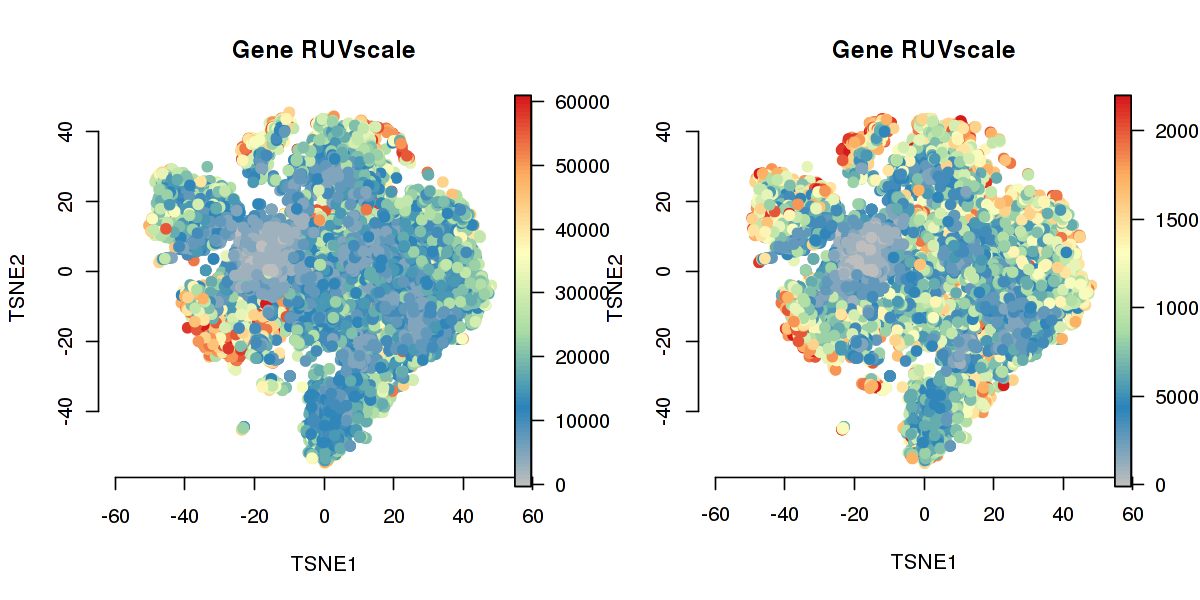

In [17]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
val=rowSums(ExpressionMat)
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

val=rowSums(ExpressionMat[,taggene_posi])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13

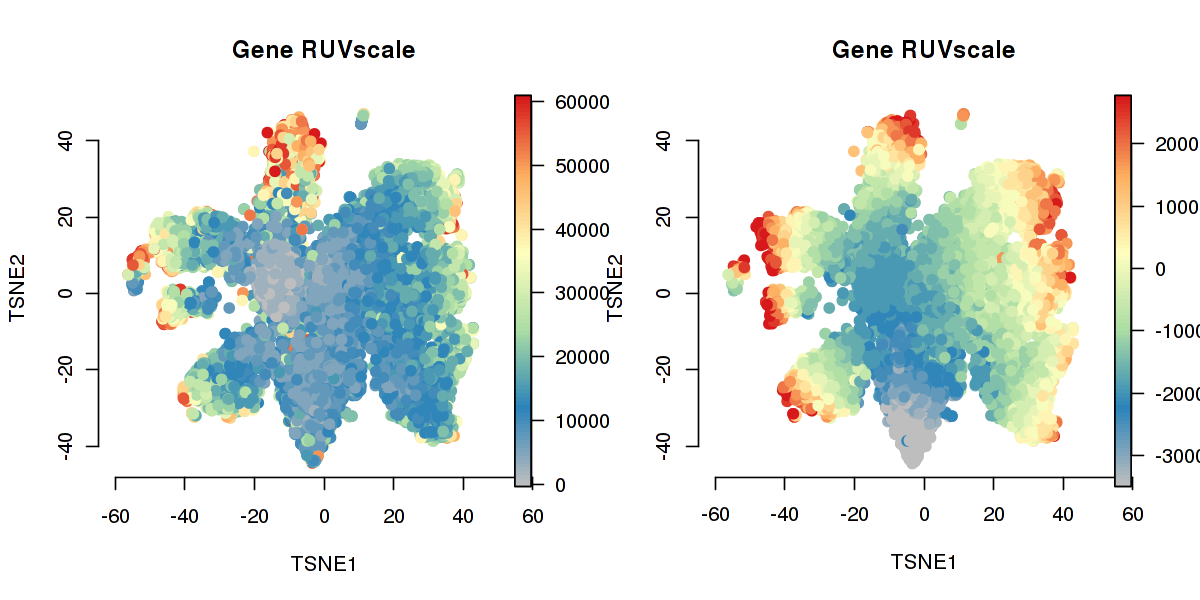

In [37]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
val=rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

val=rowSums(ExpressionMat_magic[,-grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

# not using

Loading required package: repr


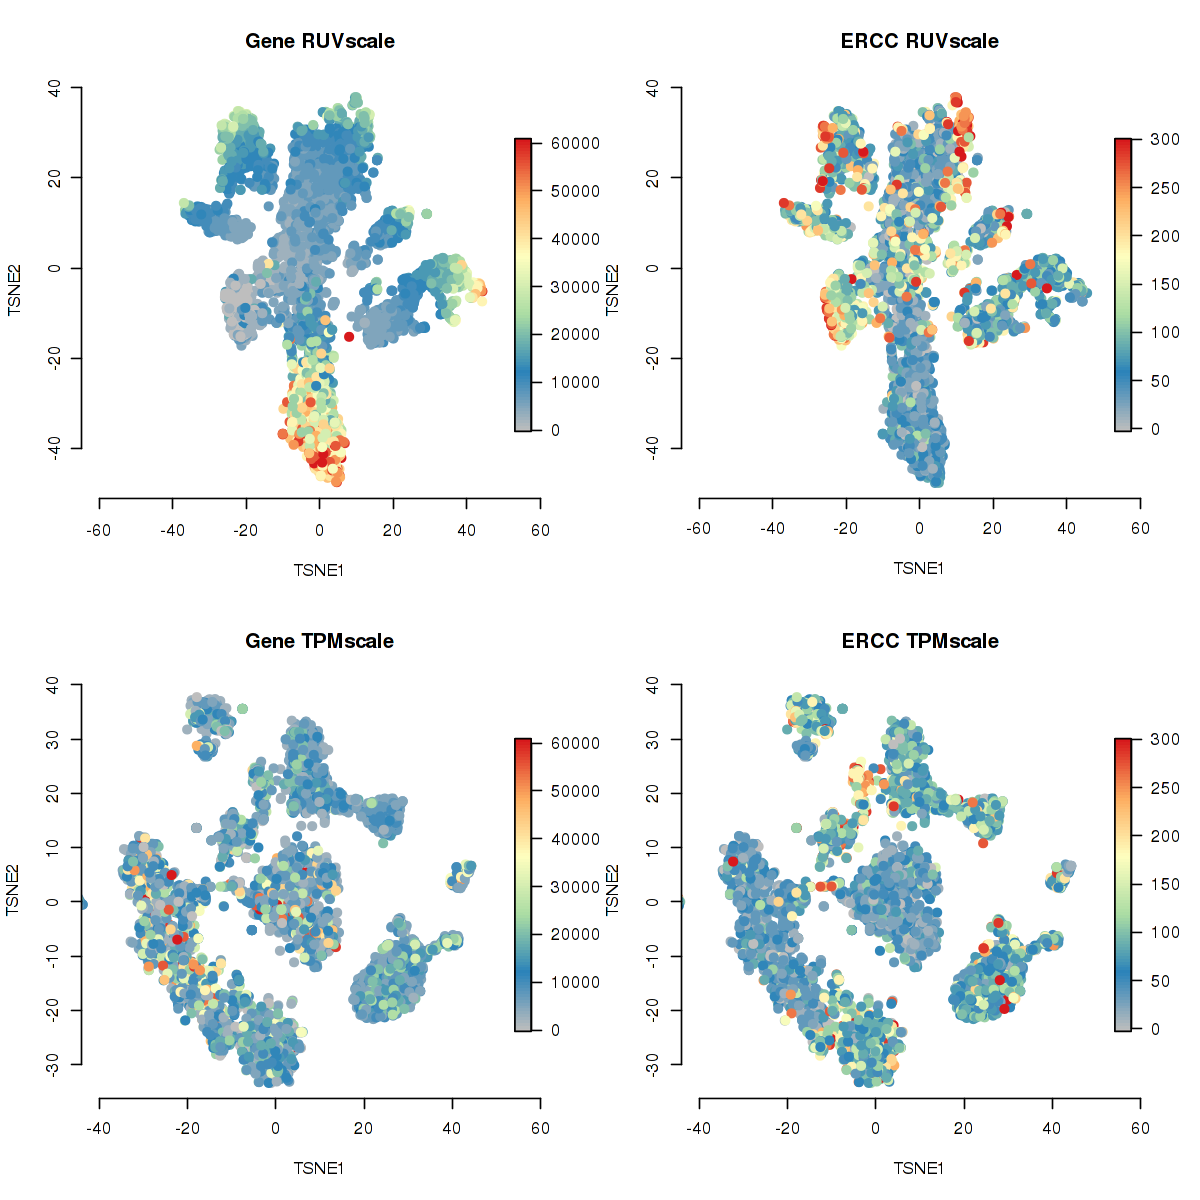

In [7]:
require(repr)
#options(repr.plot.width=10, repr.plot.height=10)
pdf("reads distribution on TSNE plot.pdf",width=10,height=10)
par(mfrow=c(2,2))
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
val=rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

val=rowSums(ExpressionMat[,grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
ERCCbreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
ERCCcols=rbPal(25)[as.numeric(cut(val,breaks = ERCCbreaks))]

load("testing_RUVscale.Rdata")
plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

plot(rtsne_allcell$Y,col=ERCCcols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="ERCC RUVscale")
fields::image.plot(legend.only=T,zlim=range(ERCCbreaks), col=rbPal(100))

load("testing_TPMscale.Rdata")
plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-40,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene TPMscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

plot(rtsne_allcell$Y,col=ERCCcols,pch=19,xlim=c(-40,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="ERCC TPMscale")
fields::image.plot(legend.only=T,zlim=range(ERCCbreaks), col=rbPal(100))
dev.off()

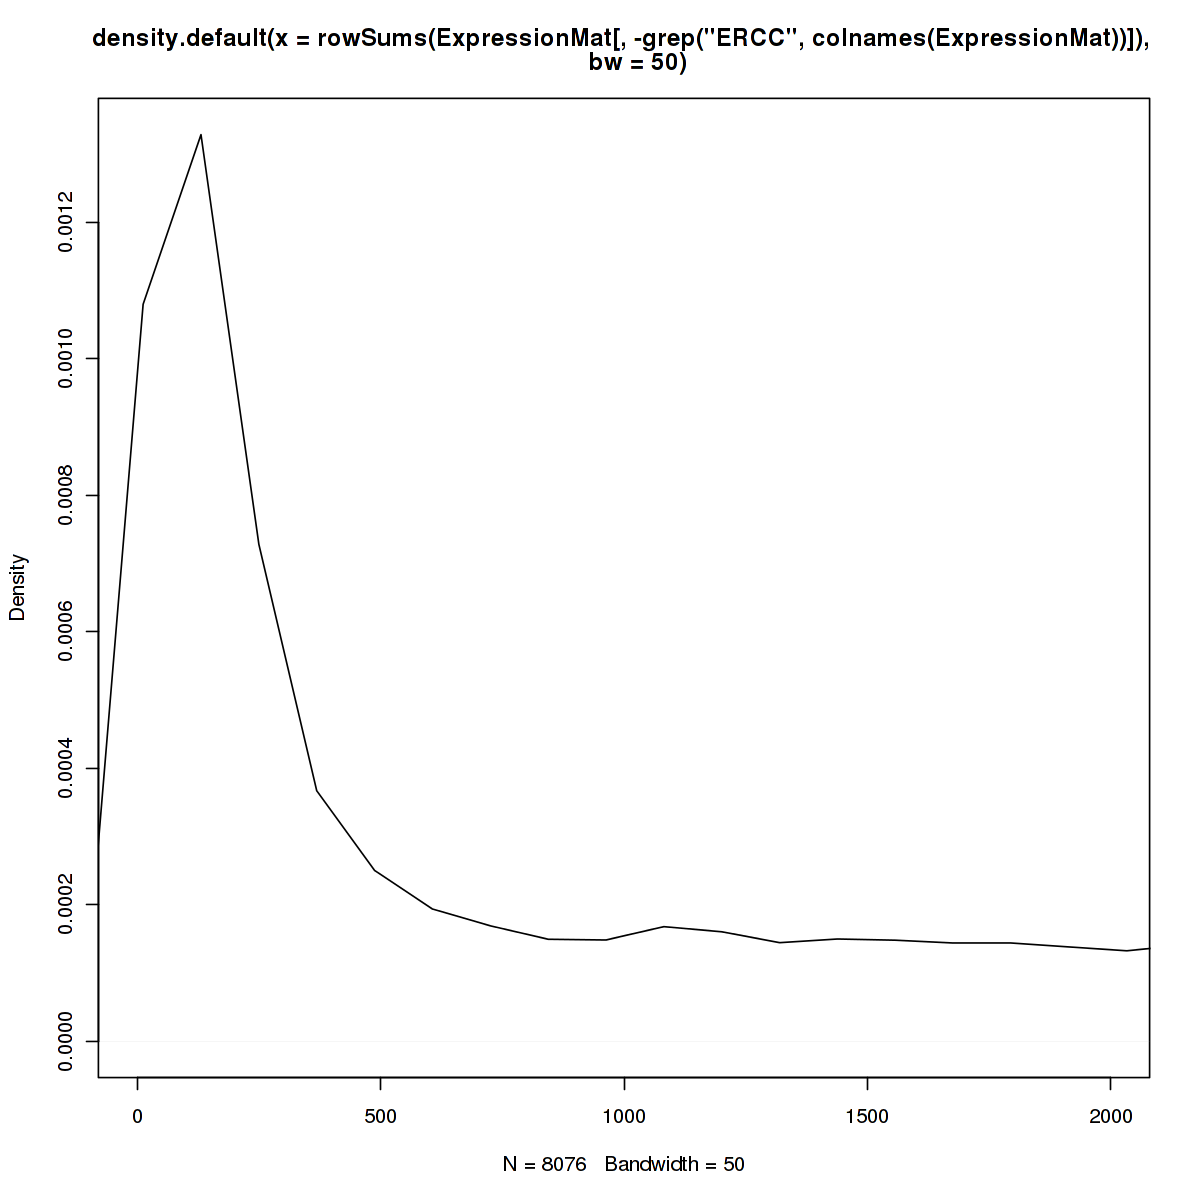

In [23]:
plot(density(rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))]),bw=50),xlim=c(0,2000))

# BCR TCR captured only

In [6]:
#using only the BCR/TCR capture cells
ExpressionMat=ExpressionMat[cell_assignment!="unknown",]
sample_gp=sample_gp[cell_assignment!="unknown"]
cell_assignment=cell_assignment[cell_assignment!="unknown"]

In [7]:
rtsne_allcell=Rtsne(ExpressionMat,dims=2,max_iter = 1000)
pca_allcell=prcomp(ExpressionMat)
save(rtsne_allcell,pca_allcell,file="TSNE_PCA_BTCRonly_out.Rdata")
#load("TSNE_PCA_BTCRonly_out.Rdata")

#require(repr)
#options(repr.plot.width=8, repr.plot.height=8)
pdf("TSNE_PCA VDJ captured only scRNAseq.pdf",width=10,height=10)
par(mfcol=c(2,2))

coltouse=cell_assignment
tagcol=RColorBrewer::brewer.pal(length(unique(cell_assignment)),"Set1")
for (i in 1:length(unique(cell_assignment))){
    coltouse[coltouse==unique(cell_assignment)[i]]=tagcol[i]
}
plot(rtsne_allcell$Y,pch=19,col=coltouse,cex=0.5,main="TSNE B/T cell label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+10))
legend("topright",unique(cell_assignment),bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=coltouse,cex=0.5,main="PCA B/T cell label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+10))
legend("topright",unique(cell_assignment),bty = "n",lty=0,pch=19,col=tagcol)

tagcol=RColorBrewer::brewer.pal(length(sample_list),"Set1")
plot(rtsne_allcell$Y,pch=19,col=tagcol[sample_gp],cex=0.5,main="TSNE PBMC/Rectum label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+10))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[sample_gp],cex=0.5,main="PCA PBMC/Rectum label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+10))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)
dev.off()

png 
  2

# Clonetype Analysis

In [ ]:
#save some BCR and TCR cells
#get all filtered TCR/BCR, see whether their v,d,j,c choice match 

In [31]:
#sample_list=c("C12pBMC","C12Rectum","C9pBMC","C9Rectum")
sample_names=c()
for(i in 1:length(sample_list)){sample_names=c(sample_names,rep(sample_list[i],nrow(TCR_annoation_list[[i]])))}
clonotype_tbl=do.call(rbind,TCR_annoation_list)
clonotype_tbl=cbind(sample_names,clonotype_tbl)


In [32]:
clonotype_tbl[1:5,]

sample_names,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
C12pBMC,AAACGGGCACGGATAG-1,TRUE,AAACGGGCACGGATAG-1_contig_1,TRUE,493,TRB,TRBV15,None,TRBJ2-3,TRBC2,TRUE,True,CATSSQASTQYF,TGTGCCACCAGCTCCCAGGCCAGTACGCAGTATTTT,2230,9,clonotype36,clonotype36_consensus_1
C12pBMC,AAACGGGCACGGATAG-1,TRUE,AAACGGGCACGGATAG-1_contig_2,TRUE,497,TRA,TRAV9-2,None,TRAJ6,TRAC,TRUE,True,CALSDSSGGSYIPTF,TGTGCTCTGAGTGATAGCTCAGGAGGAAGCTACATACCTACATTT,286,1,clonotype36,clonotype36_consensus_2
C12pBMC,AAAGATGTCAGTACGT-1,TRUE,AAAGATGTCAGTACGT-1_contig_1,TRUE,747,TRB,TRBV19,TRBD1,TRBJ1-5,TRBC1,TRUE,True,CASSADRGDQPQHF,TGTGCCAGTAGTGCGGACAGGGGGGATCAGCCCCAGCATTTT,7035,30,clonotype37,clonotype37_consensus_1
C12pBMC,AAAGATGTCAGTACGT-1,TRUE,AAAGATGTCAGTACGT-1_contig_3,TRUE,700,TRA,TRAV1-2,None,TRAJ18,TRAC,TRUE,True,CAVRGRGSTLGRLYF,TGTGCTGTGAGGGGCAGAGGCTCAACCCTGGGGAGGCTATACTTT,1892,9,clonotype37,clonotype37_consensus_2
C12pBMC,AAAGCAATCTACCAGA-1,TRUE,AAAGCAATCTACCAGA-1_contig_1,TRUE,605,TRB,TRBV7-2,TRBD2,TRBJ2-1,TRBC2,TRUE,True,CASTPGTYIYNEQFF,TGTGCCAGCACCCCCGGGACTTATATCTACAATGAGCAGTTCTTC,4252,17,clonotype38,clonotype38_consensus_1


In [5]:
load("testing_tmp.Rdata")

In [13]:
ExpressionMat_centered=scale(ExpressionMat)
nY <- naiveRandRUV(ExpressionMat_centered, grep("ERCC",colnames(ExpressionMat)), nu.coeff=1e-3, k=20)
sdY <- apply(nY[,-grep("ERCC",colnames(ExpressionMat))], 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix

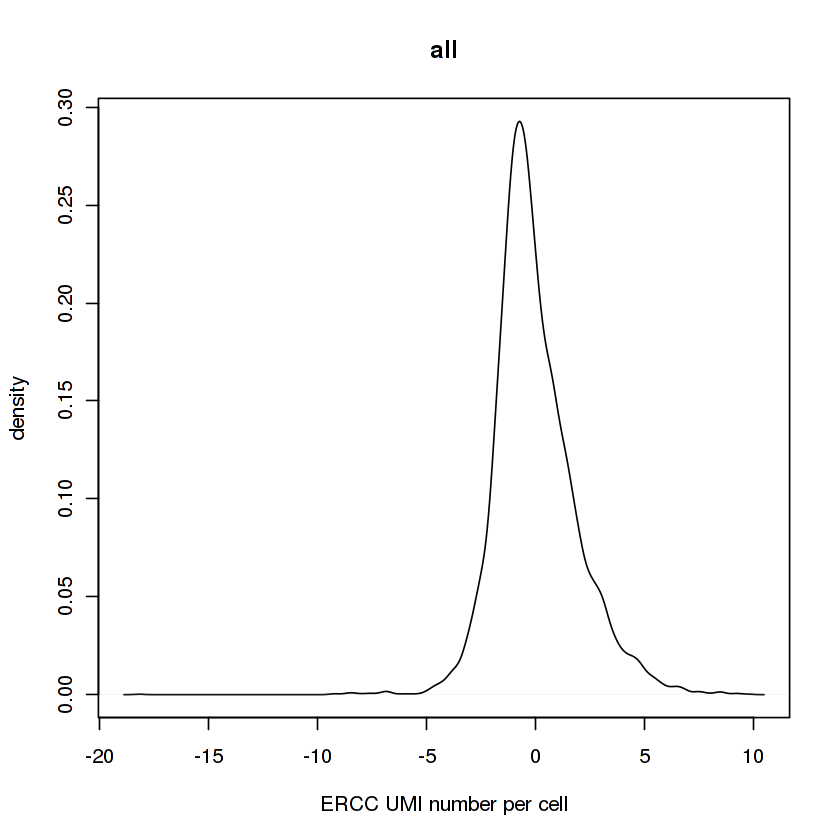

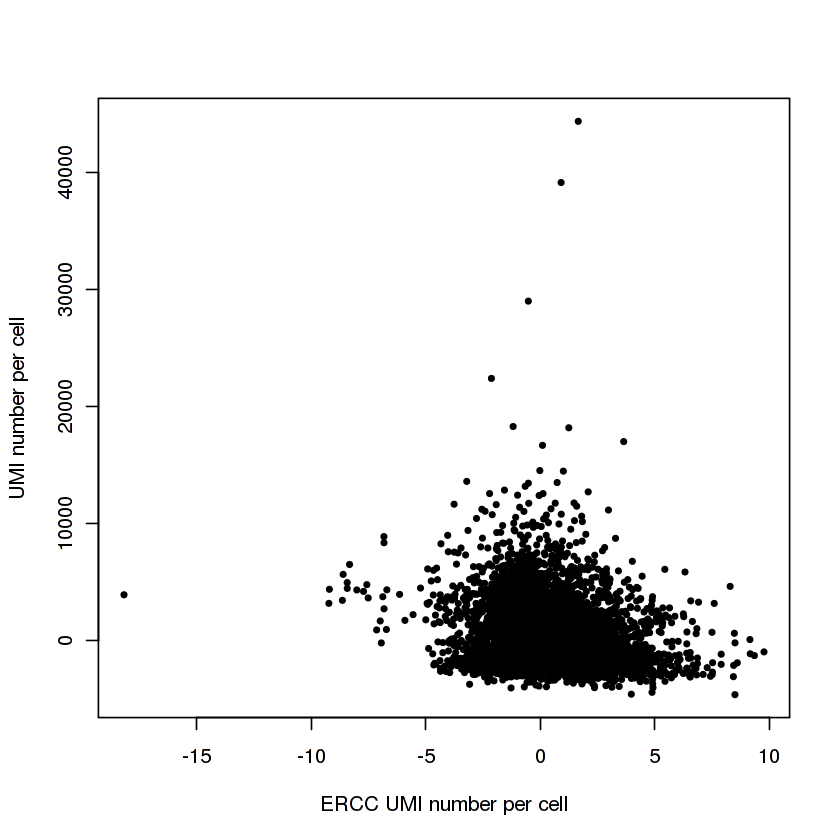

In [14]:
plot(density(rowSums(nY[,grep("ERCC",colnames(nY))])),xlab="ERCC UMI number per cell",ylab="density",main="all")
plot(rowSums(nY[,grep("ERCC",colnames(nY))]),rowSums(nY[,-grep("ERCC",colnames(nY))]),xlab="ERCC UMI number per cell",ylab="UMI number per cell",pch=19,cex=0.5)


In [41]:
which(tmp[which(rowSums(tmp)>1)[1],])

clonotype295_consensus_1                     None 
                     371                      642

In [45]:
TCR_annoation_list[[1]][TCR_annoation_list[[1]]$cdr3_nt=="TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC",]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
260,CACATAGCACAGGAGT-1,TRUE,CACATAGCACAGGAGT-1_contig_1,TRUE,591,TRB,TRBV29-1,TRBD1,TRBJ1-2,TRBC1,FALSE,None,CSVEDTGGGYTF,TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC,443,2,None,None
833,TCACGAAGTATTCGTG-1,TRUE,TCACGAAGTATTCGTG-1_contig_1,TRUE,533,TRB,TRBV29-1,TRBD1,TRBJ1-2,TRBC1,TRUE,True,CSVEDTGGGYTF,TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC,279,2,clonotype295,clonotype295_consensus_1
